# Project: Causal Uplift Modeling - Synthetic Data Simulation

This notebook simulates an educational intervention scenario to model **individual treatment effects (ITE)**.

We investigate whether giving students access to **private tutoring** (the treatment) improves their **final academic performance**.

The goal is to answer:
> *"Is it a coincidence, or does private tuition actually cause better academic outcomes?"*

This synthetic dataset allows us to:
- Inject realistic **feature dependencies and confounding**
- Define true counterfactual outcomes (`y0`, `y1`)
- Evaluate causal uplift models under controlled conditions

## Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit

## Simulate Features  

This notebook simulates 10,000 students’ exam‐related data, while factoring in realistic dependencies among five features.

### **Features and Dependencies**

| Feature           | Formula / Distribution                                   |
|-------------------|----------------------------------------------------------|
| `motivation`      | Normal(mean=0, std=1)                                    |
| `engagement`      | Bernoulli(p = sigmoid(`motivation`))                     |
| `prior_gpa`       | clip(2.5 + 0.3·`motivation` + 0.5·`engagement` + ε, 0–4) |
| `age`             | Uniform integer between 18 and 24                        |
| `study_hours`     | max(2 + 2·`private_tuition` + 1.5·`engagement` + ε, 0)   |

In [24]:
np.random.seed(42)
N = 10_000

# 1. Latent trait: Motivation (normally distributed)
motivation = np.random.normal(0, 1, N)

# 2. Engagement depends on motivation (more motivated students are more engaged)
engagement_prob = expit(1.0 * motivation)  # sigmoid to [0,1]
engagement = np.random.binomial(1, engagement_prob)

# 3. Prior GPA depends on both engagement and motivation
prior_gpa = (
    2.5
    + 0.3 * motivation
    + 0.5 * engagement
    + np.random.normal(0, 0.3, N)
)
prior_gpa = np.clip(prior_gpa, 0.0, 4.0)

# 4. Age is independent (for simplicity)
age = np.random.randint(18, 25, N)

# 5. Study hours depend on private tuition and engagement
study_hours = (
    2.0
    + 1.5 * engagement
    + np.random.normal(0, 1.0, N)
)
study_hours = np.clip(study_hours, 0, None)

# Assemble dataset
X = pd.DataFrame({
    'motivation': motivation,
    'engagement': engagement,
    'prior_gpa': prior_gpa,
    'age': age,
    'study_hours': study_hours
})

## Assign Treatment with Confounding

### **Treatment**
We determine that for a student to recieve private tuition (the treatment), they must have a low GPA, low engagement, and low motivation.
### **Propensity Score**
The propensity score is defined as the probability that a subject receives treatment given their observed features X.

$$
e(X) = P\bigl(T = 1 \mid X\bigr)
$$

In [25]:
logits = -0.8 * X['prior_gpa'] - 0.5 * X['engagement'] - 0.3 * X['motivation']
propensity = expit(logits)
X['treatment'] = np.random.binomial(1, propensity)

## Simulate Possible Outcomes (y0, y1, uplift)

We define:
- **`y0`**: The outcome if a student does *not* receive treatment.
- **`y1`**: The outcome if a student *does* receive treatment.
- **`uplift`**: The individual treatment effect (ITE), calculated as `y1 - y0`.

Treatment improves outcomes for **engaged students** who **study more than 5 hours/day**.

In [26]:
# Base outcome depends on GPA, study_hours, motivation
noise = np.random.normal(0, 0.1, N)

X['y0'] = (
    0.4 * X['prior_gpa']
    + 0.3 * X['study_hours']
    + 0.2 * X['motivation']
    + noise
)

# Treatment adds benefit to engaged students who also study more
X['y1'] = (
    X['y0']
    + 0.4 * X['engagement']
    + 0.3 * (X['study_hours'] > 5)
)

# Observed outcome based on treatment group
X['outcome'] = np.where(X['treatment'] == 1, X['y1'], X['y0'])

# True uplift (Individual Treatment Effect)
X['uplift'] = X['y1'] - X['y0']

# Binary classification label (pass/fail)
# X['outcome_binary'] = (X['outcome'] > X['outcome'].median()).astype(int)

## Save the Dataset

In [27]:
X.to_csv("data/synthetic_education_uplift.csv", index=False)

## Visualisations

### Feature Correlation Matrix
We use a heatmap to see how the features: motivation, engagement, GPA, study hours, and treatment are correlated.

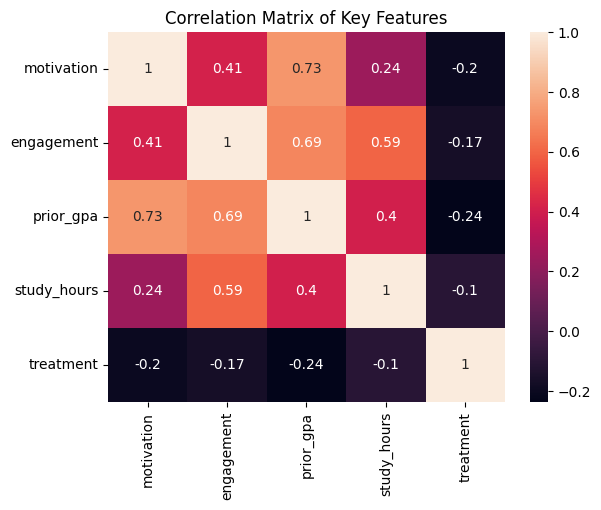

Treated count: 1029
Control count: 8971


In [28]:
# Heat map
sns.heatmap(X[['motivation', 'engagement', 'prior_gpa', 'study_hours', 'treatment']].corr(), annot=True)
plt.title("Correlation Matrix of Key Features")
plt.show()

# Summary
print("Treated count:", X['treatment'].sum())
print("Control count:", (1 - X['treatment']).sum())

#### **Interpretation**
This confirms that motivation positively correlates with engagement and prior_gpa, as expected. The negative correlation between treatment and all other features reflects our confounding logic, which was that students with lower GPA, motivation, and engagement are more likely to receive private tuition.

### Distribution of Propensity Scores
A distribution showing the probability of being assigned the treatment among the population.

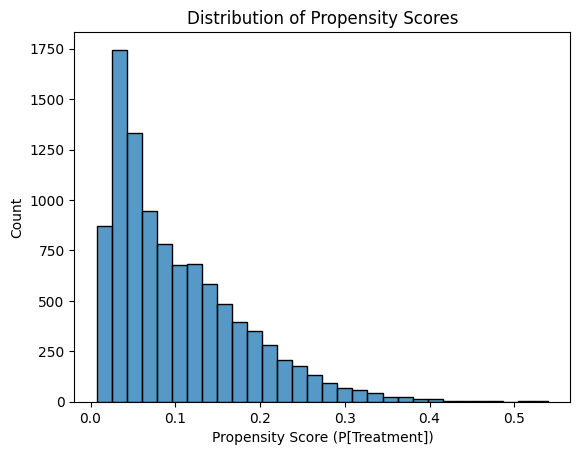

In [29]:
# Histogram of propensity scores
sns.histplot(propensity, bins=30)
plt.title("Distribution of Propensity Scores")
plt.xlabel("Propensity Score (P[Treatment])")
plt.show()

#### **Interpretation**

Most students have a low probability of being treated. This is because private tuition is targeted at students with below-average motivation, GPA, and engagement, which is only a small proportion of the full population. This imbalance is realistic, and will force uplift models to generalise from limited treated examples.

### Distribution of Individual Treatment Effects (ITE)
A plot of the true uplift for each student calculated by `y1 - y0`

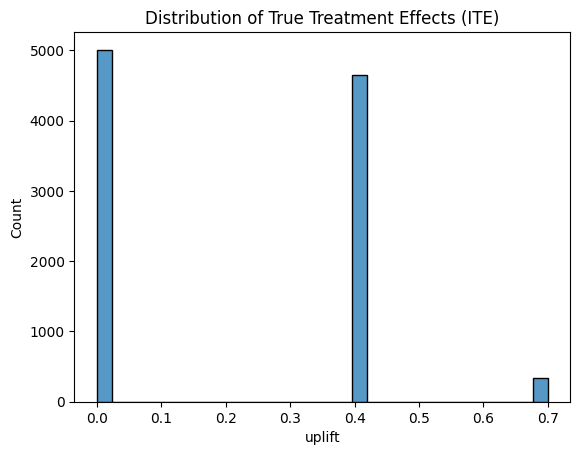

In [36]:
# Histogram of uplift
sns.histplot(X['uplift'], bins=30)
plt.title("Distribution of True Treatment Effects (ITE)");

#### **Interpretation**

The ITE distribution is tri-modal:
- Many students have **no uplift**. These students are likely not engaged or don’t study enough for tuition to help.
- A large group has **moderate uplift**. These students are likely engaged with moderate study habits.
- A small group shows **significant uplift**. These represent the engaged students who study a lot (>5 hours/day).

This structure reflects heterogeneous treatment effects, perfect for testing causal uplift models.

### GPA Distributions by Treatment Group
We compare GPA between treated and untreated students to confirm confounding.


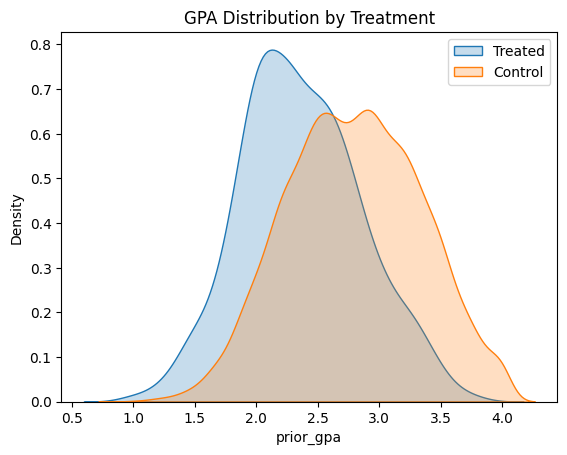

In [34]:
sns.kdeplot(X[X['treatment'] == 1]['prior_gpa'], label='Treated', fill=True)
sns.kdeplot(X[X['treatment'] == 0]['prior_gpa'], label='Control', fill=True)
plt.title("GPA Distribution by Treatment")
plt.legend()
plt.show()

#### **Interpretation**
Treated students clearly have lower GPA on average compared to control. This confirms that treatment assignment is confounded and that GPA is a strong driver of treatment assignment. This validates the need for causal adjustment methods like propensity scoring.

### Propensity Score vs GPA
Visualises how GPA affects treatment assignment.

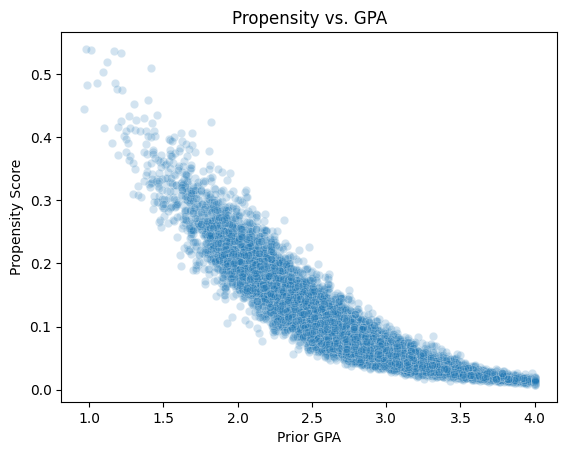

In [32]:
sns.scatterplot(x=X['prior_gpa'], y=propensity, alpha=0.2)
plt.title("Propensity vs. GPA")
plt.xlabel("Prior GPA")
plt.ylabel("Propensity Score")
plt.show()

#### **Interpretation**

There is a strong negative relationship between GPA and treatment probability. As GPA increases, students are less likely to be offered private tuition. This visual makes the treatment assignment mechanism transparent.

## Summary Stats
- Total students: 10,000  
- Treated: `X['treatment'].sum()`  
- Control: `(1 - X['treatment']).sum()`  
- Treatment was assigned based on low GPA, low motivation, and low engagement.
- Uplift varies across subgroups (stronger for engaged students studying more than 5h/day).

In [33]:
print("Treated count:", X['treatment'].sum())
print("Control count:", (1 - X['treatment']).sum())

Treated count: 1029
Control count: 8971


## Simulation Validation Summary

This section confirms that our synthetic dataset behaves as expected:

- **Confounding works**: GPA, motivation, and engagement all negatively influence treatment assignment. This is visible in the correlation matrix and GPA density plot.
- **Treatment is imbalanced**: Most students are untreated, as tuition only targets low-performing students.
- **Uplift is heterogeneous**: Only specific subgroups (engaged + high study hours) benefit significantly, ideal for evaluating uplift models.
- **Treatment assignment logic is visible**: Propensity vs GPA scatterplot mirrors our treatment assignment formula.

These signals confirm our synthetic simulation is realistic, confounded, and ready for causal modeling.


## Next Steps

- Train uplift models (T-X-learners, Causal Forests) on this synthetic dataset.
- Evaluate performance against true ITE (`y1 - y0`) using:
  - Mean Squared Error (MSE)
  - Qini Curve, AUUC
- Explore feature importance and segment-wise uplift analysis.
- Apply same pipeline on real-world dataset (e.g., Criteo Uplift).

See: `02_model_synthetic.ipynb`
